<a href="https://colab.research.google.com/github/seansothey/Research_Project/blob/main/Diabetic_Retinopathy_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://d2zo993x2i1w0h.cloudfront.net/live/2019/01/what-causes-diabetic-retinopathy-1024x642.jpg)

##Overview
Diabetic retinopathy is the leading cause of blindness in the working-age population of the developed world. It is estimated to affect over 93 million people.
The US Center for Disease Control and Prevention estimates that 29.1 million people in the US have diabetes and the World Health Organization estimates that 347 million people have the disease worldwide. Diabetic Retinopathy (DR) is an eye disease associated with long-standing diabetes. Around 40% to 45% of Americans with diabetes have some stage of the disease. Progression to vision impairment can be slowed or averted if DR is detected in time, however this can be difficult as the disease often shows few symptoms until it is too late to provide effective treatment.
Currently, detecting DR is a time-consuming and manual process that requires a trained clinician to examine and evaluate digital color fundus photographs of the retina. By the time human readers submit their reviews, often a day or two later, the delayed results lead to lost follow up, miscommunication, and delayed treatment.
Clinicians can identify DR by the presence of lesions associated with the vascular abnormalities caused by the disease. While this approach is effective, its resource demands are high. The expertise and equipment required are often lacking in areas where the rate of diabetes in local populations is high and DR detection is most needed. As the number of individuals with diabetes continues to grow, the infrastructure needed to prevent blindness due to DR will become even more insufficient.
The need for a comprehensive and automated method of DR screening has long been recognized, and previous efforts have made good progress using image classification, pattern recognition, and machine learning. With color fundus photography as input, the goal is to build an automated detection system to the limit of what is possible – ideally resulting in models with realistic clinical potential that can improve DR detection. This process requires many machine learning tasks and techniques to build a good classifier. To start, it is essential to obtain enough datasets, including useful information, such as number of attributes and classes.

##Datasets Description
The datasets are in image format with a large set of high-resolution retina images taken under a variety of imaging conditions. A left and right field is provided for every subject. Images are labeled with a subject id as well as either left or right (e.g. 1_left.jpeg is left eye of patient id 1).
Each image has been rated by clinicians on a scale 0 to 4 according to the presence of diabetic retinopathy.

*   0 - No DR
*   1 - Mild
*   2 - Moderate
*   3 - Severe
*   4 - Proliferative DR

The acquired images are in RGB form with high resolution JPEG format. Due to the extremely large size of this dataset, total to 82.23 GB, it was separated into archive folders. Each folder has around 8400 images, and total size about 8 GB. 
*   train.zip - the training set (5 folders)
*   test.zip - the test set (7 folders)
*   trainLabels.csv - contains the scores (0 to 4) for the training set

Dataset link: https://www.kaggle.com/c/diabetic-retinopathy-detection/data









#Setup

In [1]:
#!pip install tensorflow-gpu

In [2]:
!nvidia-smi

Sun Oct 25 03:07:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Common Import
import sklearn
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import os

import cv2
from google.colab.patches import cv2_imshow

# to make this notebook's output stable across runs
np.random.seed(168)

from zipfile import ZipFile

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")

# sklearn version > 0.20 is required 
sklearn.__version__
# Update sklearn -> !pip install -U scikit-learn

'0.22.2.post1'

Connect to google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessing Data

In [ ]:
!unzip "/content/drive/My Drive/new_dataset.zip"

In [6]:
DR_data = os.listdir('/content/new_dataset')

In [7]:
len(DR_data)

1243

###Create the images dataset

In [135]:
def create_img_set(imgs_folder_path):
  x=[]
  lst = os.listdir(imgs_folder_path)
  for img in lst:
    img_imr = cv2.imread(os.path.join(imgs_folder_path, img))
    img_imr = cv2.resize(img_imr,(256,256)) # resize images
    x.append(np.array(img_imr))
  return x

In [136]:
data = create_img_set(os.path.join('/content/new_dataset'))

Show some images

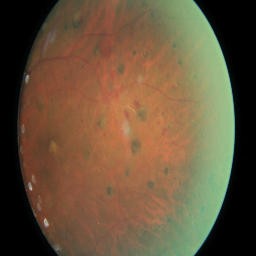

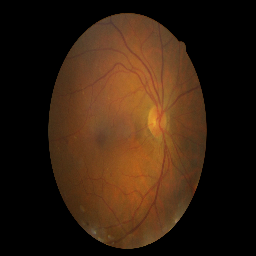

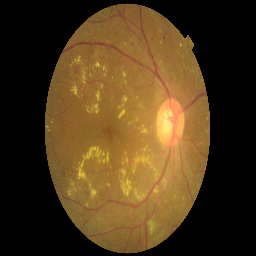

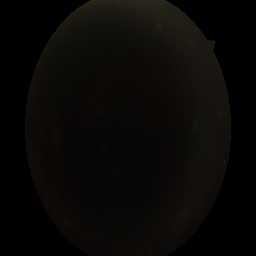

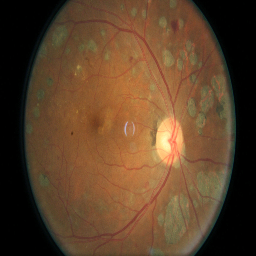

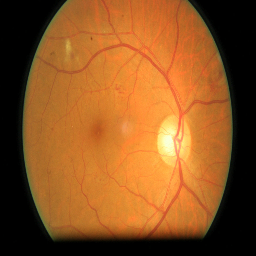

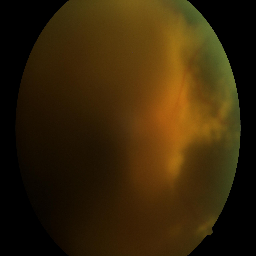

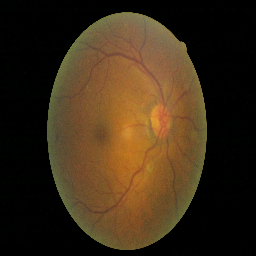

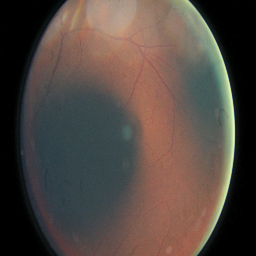

In [137]:
for i in range(0,9):
  cv2_imshow(data[i])

###Flattening the images dataset

In [138]:
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.inception_v3 import preprocess_input

preprocess = imagenet_utils.preprocess_input

In [139]:
new_data = preprocess(np.array(data))

In [140]:
new_data.shape

(1243, 256, 256, 3)

In [141]:
new_data = new_data/255.0

###Create label y

In [118]:
all_label = pd.read_csv("/content/trainLabels.csv")

In [119]:
all_label

image  level
0          10_left      0
1         10_right      0
2          13_left      0
3         13_right      0
4          15_left      1
...            ...    ...
35121  44347_right      0
35122   44348_left      0
35123  44348_right      0
35124   44349_left      0
35125  44349_right      1

[35126 rows x 2 columns]

Let's check if the classes are balanced

In [120]:
print(all_label.groupby('level').nunique())

       image
level       
0      25810
1       2443
2       5292
3        873
4        708


Let's extract labels

In [121]:
label = []

In [122]:
file_dir = os.path.join('/content/train')
files = [os.path.join(file_dir, fname) for fname in DR_data]
for fname in DR_data:
  label.append(fname.split(".")[0]) 

In [123]:
label = pd.DataFrame(label,columns=['image'])

In [124]:
label

image
0     11492_right
1      1919_right
2      3444_right
3       1475_left
4       2970_left
...           ...
1238   2767_right
1239     70_right
1240   1987_right
1241     170_left
1242     280_left

[1243 rows x 1 columns]

In [125]:
new_label = pd.merge(label, all_label, on=['image'])

In [126]:
new_label

image  level
0     11492_right      4
1      1919_right      2
2      3444_right      3
3       1475_left      2
4       2970_left      4
...           ...    ...
1238   2767_right      3
1239     70_right      0
1240   1987_right      2
1241     170_left      0
1242     280_left      0

[1243 rows x 2 columns]

Check the balance of the classes

In [127]:
print(new_label.groupby('level').nunique())

       image
level       
0        249
1        244
2        250
3        250
4        250


Let's verify with first and last file name to see if it's matched.

In [142]:
DR_data[0], new_label['image'][0]

('11492_right.jpeg', '11492_right')

In [27]:
DR_data[500], new_label['image'][500]

('1412_left.jpeg', '1412_left')

In [28]:
DR_data[1000], new_label['image'][1000]

('104_left.jpeg', '104_left')

Therefore, the new label is created correctly and good to go!!!

In [129]:
target = new_label['level']

Convert to categorical 

In [131]:
class_name = ['No DR','Mild','Moderate','Severe','Proliferative DR']

In [166]:
y = to_categorical(target, num_classes=len(class_name))

Split training and testing set 80:20

In [169]:
X_train, X_test, y_train, y_test = train_test_split(new_data, y, test_size=0.2, random_state=42)

In [170]:
X_train.shape, y_train.shape

((994, 256, 256, 3), (994, 5))

##Transfer Learning - Keras Model Xception

In [148]:
from keras.models import Model
from keras.layers import Dense,Flatten,GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.utils import np_utils
import glob

In [149]:
model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))

58892288/58889256 [==============================] - 1s 0us/step


In [150]:
# New Layers which will be trained on our data set and will be stacked over the Xception Model
x=model.output
#x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
x=Dense(256,activation='relu')(x)
x=Dense(64,activation='relu')(x)
output=Dense(len(class_name),activation='softmax')(x)

In [151]:
# Freezing all the Imported Layers because we don't train existing weights
for layers in model.layers:
	layers.trainable=False

In [152]:
New_Model=Model(model.input,output)
New_Model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)     

In [72]:
from keras.utils.vis_utils import plot_model
plot_model(New_Model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [153]:
New_Model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

##Training the model

In [171]:
tr = New_Model.fit(X_train,y_train,
                   batch_size=32,epochs=100, 
                   validation_split = 0.1)

Epoch 1/100


ValueError: ignored

In [ ]:
score5 = cnn5.evaluate(X_test, y_test_cat, verbose=0)
print('Test loss:', score5[0])
print('Test accuracy:', score5[1])

It's very low, let's try some more layers and augument dataset.

###See the prediction

In [ ]:
pred_test = cnn5.predict_classes(X_test, verbose=0)

###Plot the learning curve

In [ ]:
plt.plot(tr5.history['accuracy'])
plt.plot(tr5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(tr5.history['loss'])
plt.plot(tr5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Save the model as h5 file
from tensorflow.keras.models import load_model
cnn5.save('CNN5_Layers.h5')

###Classification Report

In [ ]:
from sklearn.metrics import classification_report
#target_names = ["Class {}".format(i) for i in range(6)]
print(classification_report(y_test, pred_test, target_names=class_name))

###Confusion Matrix

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

fig, ax = plt.subplots(figsize=(8,8)) 
mat = confusion_matrix(pred_test, y_test)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=class_name,
            yticklabels=class_name)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')